In [54]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Advanced data visualization
import sklearn  # Machine learning utilities

# Importing machine learning models
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  
from sklearn.linear_model import LinearRegression  
import xgboost as xgb  # XGBoost model

# Model evaluation and preprocessing
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score  
from collections import Counter  # Counting occurrences in datasets

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


In [81]:
# Define file names for attack-related datasets
file_name_1 = 'server_syn_flood_1.csv'
file_name_2 = 'syn_flood_random_ip.csv'

# Load and preprocess first attack dataset
file_1 = pd.read_csv(file_name_1)
file_1 = file_1.drop(columns=['No.', 'Time'], axis=1)  # Remove unnecessary columns
file_1 = file_1.drop_duplicates(ignore_index=True)  # Remove duplicate rows

# Load and preprocess second attack dataset
file_2 = pd.read_csv(file_name_2)
file_2 = file_2.drop(columns=['No.', 'Time'], axis=1)
file_2 = file_2.drop_duplicates(ignore_index=True)

# Label attack datasets as attack (1)
file_1.insert(np.shape(file_1)[1], "IsAttack?", 0)
file_2.insert(np.shape(file_2)[1], "IsAttack?", 1)

# Define file names for normal traffic datasets
DF_1 = 'server_normal_traffic.csv'
DF_2 = 'general_network_traffic.csv'

# Load and preprocess normal traffic dataset 1
df_1 = pd.read_csv(DF_1)
df_1 = df_1.drop(columns=['No.', 'Time'], axis=1)
df_1 = df_1.drop_duplicates(ignore_index=True)

# Load and preprocess normal traffic dataset 2
df_2 = pd.read_csv(DF_2)
df_2 = df_2.drop(columns=['No.', 'Time'], axis=1)
df_2 = df_2.drop_duplicates(ignore_index=True)

# Combine normal traffic datasets
df = pd.concat([df_1, df_2], ignore_index=True)

# Label normal traffic as non-attack (0)
df.insert(np.shape(df)[1], "IsAttack?", 0)

# Identify potential attack patterns based on 'Info' column
count = 0
for i in range(np.shape(df)[0]):
    a = df['Info'][i].split(' ')  # Split string into words
    try:
        b = a.index('Exception' or 'exception')  # Check for "Exception" keyword
        if a[b+1] == 'returned':  # If the next word is "returned", mark as attack
            df['IsAttack?'][i] = 1
            count += 1
    except:
        pass  # Ignore errors for missing keywords

# Merge attack and normal traffic datasets into a final dataset
df = pd.concat([df, file_1, file_2], ignore_index=True)


In [56]:
# Remove duplicate rows from the final dataset
df = df.drop_duplicates(ignore_index=True)
df.head()

,Source,Destination,Protocol,Length,Info,IsAttack?
0,PcsCompu_22:46:4f,Broadcast,ARP,60,Who has 192.168.56.113? Tell 192.168.56.114,0
1,PcsCompu_75:69:b0,PcsCompu_22:46:4f,ARP,42,192.168.56.113 is at 08:00:27:75:69:b0,0
2,192.168.56.114,192.168.56.113,TCP,74,36610 > 502 [SYN] Seq=0 Win=64240 Len=0 MSS=...,0
3,192.168.56.113,192.168.56.114,TCP,74,"502 > 36610 [SYN, ACK] Seq=0 Ack=1 Win=65160...",0
4,192.168.56.114,192.168.56.113,TCP,66,36610 > 502 [ACK] Seq=1 Ack=1 Win=64256 Len=...,0


In [57]:
# Remove the 'Info' column as it is no longer needed
df.drop(columns=['Info'], axis=1)

,Source,Destination,Protocol,Length,IsAttack?
0,PcsCompu_22:46:4f,Broadcast,ARP,60,0
1,PcsCompu_75:69:b0,PcsCompu_22:46:4f,ARP,42,0
2,192.168.56.114,192.168.56.113,TCP,74,0
3,192.168.56.113,192.168.56.114,TCP,74,0
4,192.168.56.114,192.168.56.113,TCP,66,0
...,...,...,...,...,...
430913,13.229.250.8,192.168.56.113,TCP,54,1
430914,224.168.77.124,192.168.56.113,TCP,54,1
430915,130.136.216.64,192.168.56.113,TCP,54,1
430916,82.246.78.254,192.168.56.113,TCP,54,1


In [58]:
# Count and display the number of occurrences of each class (attack vs. non-attack)
df['IsAttack?'].value_counts()

IsAttack?
0    296923
1    133995
Name: count, dtype: int64

In [59]:
# Function to replace categorical values with unique numerical identifiers
def replace_with_unique_number(data, mapping):
    return data.map(mapping)

# Define columns to be encoded
selected_columns = ['Source', 'Destination', 'Protocol']

# Create a mapping dictionary for unique values
mapping = {}
unique_values = df[selected_columns].stack().unique()  
for i, value in enumerate(unique_values, 1):
    mapping[value] = i  

# Apply the mapping to replace categorical values with numbers
for column in selected_columns:
    df[column] = replace_with_unique_number(df[column], mapping)

# Display the first few rows of the updated dataset
df.head()


,Source,Destination,Protocol,Length,Info,IsAttack?
0,1,2,3,60,Who has 192.168.56.113? Tell 192.168.56.114,0
1,4,1,3,42,192.168.56.113 is at 08:00:27:75:69:b0,0
2,5,6,7,74,36610 > 502 [SYN] Seq=0 Win=64240 Len=0 MSS=...,0
3,6,5,7,74,"502 > 36610 [SYN, ACK] Seq=0 Ack=1 Win=65160...",0
4,5,6,7,66,36610 > 502 [ACK] Seq=1 Ack=1 Win=64256 Len=...,0


In [60]:
# Remove the 'Info' column as it is no longer needed
df = df.drop(columns=['Info'], axis=1)

In [61]:
# Shuffle dataset and split into training and development sets
df = df.sample(frac=1)
train_df=df[:300000]
dev_df=df[300000:]

In [62]:
# Separate features (X) and target variable (y) for training data
y = train_df['IsAttack?']
X = train_df.drop(['IsAttack?'], axis=1)

# Separate features (X_test) and target variable (y_test) for development data
y_test = dev_df['IsAttack?']
X_test = dev_df.drop(['IsAttack?'], axis=1)

In [63]:
# Standardize features to improve model performance
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

# Train a Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model's accuracy
accuracy_score(y_test, y_pred)

0.6912876762553659

In [64]:
# Define a list of machine learning models to test
models = [
    LinearRegression(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    SVC(),
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [65]:
results = []
# Iterate through each model and evaluate using cross-validation
for model in models:
    print('\n',model.__class__.__name__,':')
    scores = cross_val_score(model, X, y, cv=6)
    
    print('\t |-->',scores)
    results.append(
        {
            'name':model.__class__.__name__,
            'mean_result':np.mean(scores),
            'max_result':max(scores)
        }
    )


 LinearRegression :
	 |--> [0.4802376  0.46353219 0.38447728 0.37544565 0.34071334 0.39619907]

 LinearDiscriminantAnalysis :
	 |--> [0.99858 0.99874 0.99782 0.99822 0.99834 0.9983 ]

 QuadraticDiscriminantAnalysis :
	 |--> [0.68826 0.68708 0.68902 0.68926 0.69056 0.68944]

 SVC :
	 |--> [0.99996 0.99992 0.99992 0.99998 0.99994 0.99996]

 LogisticRegression :
	 |--> [0.99858 0.99876 0.99782 0.99976 0.99832 0.99974]

 KNeighborsClassifier :
	 |--> [0.99996 0.99992 0.99992 0.99998 0.99994 0.99996]

 GaussianNB :
	 |--> [0.68828 0.68708 0.68896 0.68918 0.69056 0.6894 ]

 DecisionTreeClassifier :
	 |--> [0.99996 0.9999  0.99998 0.99998 0.99996 0.99994]

 RandomForestClassifier :
	 |--> [0.99996 0.9999  0.99998 1.      0.99998 0.99992]


In [66]:
# Convert the results list into a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results)
results_df

,name,mean_result,max_result
0,LinearRegression,0.406768,0.480238
1,LinearDiscriminantAnalysis,0.998333,0.998740
2,QuadraticDiscriminantAnalysis,0.688937,0.690560
3,SVC,0.999947,0.999980
4,LogisticRegression,0.998830,0.999760
5,KNeighborsClassifier,0.999947,0.999980
6,GaussianNB,0.688910,0.690560
7,DecisionTreeClassifier,0.999953,0.999980
8,RandomForestClassifier,0.999957,1.000000


In [67]:
name = []
value = []

In [68]:
# Initialize and train the Linear Discriminant Analysis (LDA) model
_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
_LinearDiscriminantAnalysis.fit(X, y)

# Predict on the test set
ypred_LinearDiscriminantAnalysis = _LinearDiscriminantAnalysis.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_LinearDiscriminantAnalysis))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_LinearDiscriminantAnalysis) * 100
print("Accuracy: ", accuracy)

# Store results for later comparison
name.append('LDA')
value.append(accuracy)


              precision    recall  f1-score   support

           0       0.99      0.56      0.71     90502
           1       0.50      0.99      0.66     40416

    accuracy                           0.69    130918
   macro avg       0.74      0.77      0.69    130918
weighted avg       0.84      0.69      0.70    130918

Accuracy:  68.95079362654486


In [69]:
# Initialize and train the Quadratic Discriminant Analysis (QDA) model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

# Predict on the test set
y_predict = qda.predict(X_test)

# Print the classification report for performance evaluation (note: incorrect variable used here)
print(classification_report(y_test, y_predict))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_predict) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('QDA')
value.append(accuracy)


              precision    recall  f1-score   support

           0       1.00      0.55      0.71     90502
           1       0.50      0.99      0.66     40416

    accuracy                           0.69    130918
   macro avg       0.75      0.77      0.69    130918
weighted avg       0.84      0.69      0.70    130918

Accuracy: 68.93475305152845


In [70]:
# Initialize and train the Support Vector Classifier (SVC) model
_svc = SVC()
_svc.fit(X, y)

# Predict on the test set
ypred_SVC = _svc.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_SVC))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_SVC) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('SVC')
value.append(accuracy)


              precision    recall  f1-score   support

           0       0.69      1.00      0.82     90502
           1       0.00      0.00      0.00     40416

    accuracy                           0.69    130918
   macro avg       0.35      0.50      0.41    130918
weighted avg       0.48      0.69      0.57    130918

Accuracy: 69.1287676255366


In [71]:
# Initialize and train the Logistic Regression model
_LogisticRegression = LogisticRegression()
_LogisticRegression.fit(X, y)

# Predict on the test set
ypred_LogisticRegression = _LogisticRegression.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_LogisticRegression))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_LogisticRegression) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('Logistic \n Regression')
value.append(accuracy)

              precision    recall  f1-score   support

           0       0.69      1.00      0.82     90502
           1       0.00      0.00      0.00     40416

    accuracy                           0.69    130918
   macro avg       0.35      0.50      0.41    130918
weighted avg       0.48      0.69      0.57    130918

Accuracy: 69.1287676255366


In [72]:
# Initialize and train the K-Nearest Neighbors (kNN) classifier
_KNeighborsClassifier = KNeighborsClassifier()
_KNeighborsClassifier.fit(X, y)

# Predict on the test set
ypred_KNeighborsClassifier = _KNeighborsClassifier.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_KNeighborsClassifier))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_KNeighborsClassifier) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('kNN')
value.append(accuracy)


              precision    recall  f1-score   support

           0       0.50      0.45      0.47     90502
           1       0.01      0.01      0.01     40416

    accuracy                           0.31    130918
   macro avg       0.25      0.23      0.24    130918
weighted avg       0.35      0.31      0.33    130918

Accuracy: 31.05913625322721


In [73]:
# Initialize and train the Gaussian Naïve Bayes model
_GaussianNB = GaussianNB()
_GaussianNB.fit(X, y)

# Predict on the test set
ypred_GaussianNB = _GaussianNB.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_GaussianNB))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_GaussianNB) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('Naïve \n Bayes')
value.append(accuracy)

              precision    recall  f1-score   support

           0       0.69      1.00      0.82     90502
           1       0.00      0.00      0.00     40416

    accuracy                           0.69    130918
   macro avg       0.35      0.50      0.41    130918
weighted avg       0.48      0.69      0.57    130918

Accuracy: 69.1287676255366


In [74]:
# Initialize and train the Random Forest Classifier
_RandomForestClassifier = RandomForestClassifier()
_RandomForestClassifier.fit(X, y)

# Predict on the test set
ypred_RandomForestClassifier = _RandomForestClassifier.predict(X_test)

# Print the classification report for performance evaluation
print(classification_report(y_test, ypred_RandomForestClassifier))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, ypred_RandomForestClassifier) * 100
print("Accuracy:", accuracy)

# Store results for later comparison
name.append('Random \n Forest')
value.append(accuracy)


              precision    recall  f1-score   support

           0       0.97      0.07      0.13     90502
           1       0.32      0.99      0.49     40416

    accuracy                           0.35    130918
   macro avg       0.65      0.53      0.31    130918
weighted avg       0.77      0.35      0.24    130918

Accuracy: 35.403076735055535


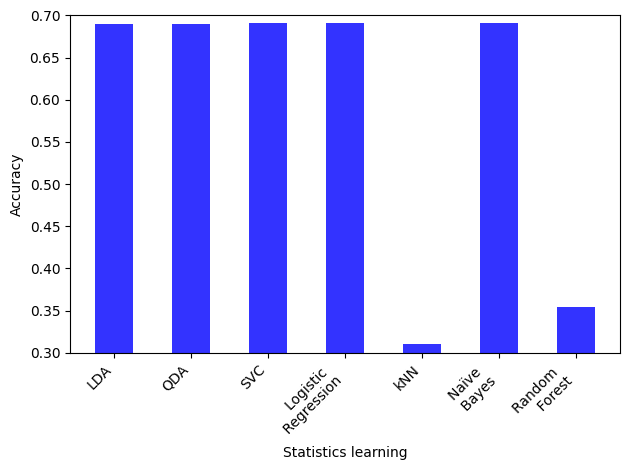

In [75]:
# Copy and normalize the dataset
labels = name.copy()
values = (np.array(value)/100).copy()

# Initialize the bar chart
fig, ax = plt.subplots()

# Define bar positions along the x-axis
x_pos = np.arange(len(labels))

# Set the width of the bars
width = 0.5

# Generate the bar plot with specified color and transparency
rects = ax.bar(x_pos, values, width, color='b', alpha=0.8)

# Set x-axis labels and rotate them for better readability
for i, rect in enumerate(rects):
    height = rect.get_height()
    
# Label the axes
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Statistics learning')
ax.set_ylabel('Accuracy')
# Set the y-axis range to ensure meaningful visualization
plt.ylim(0.3, 0.7)

# Adjust layout for better visualization
plt.tight_layout()

plt.show()


In [76]:
# Remove specific elements from labels and values lists
del labels[4]
values = list(values)  # Convert values to a list if it's not already
del values[4]
del labels[5]
del values[5]

# Convert values back to a NumPy array
values = np.array(values)


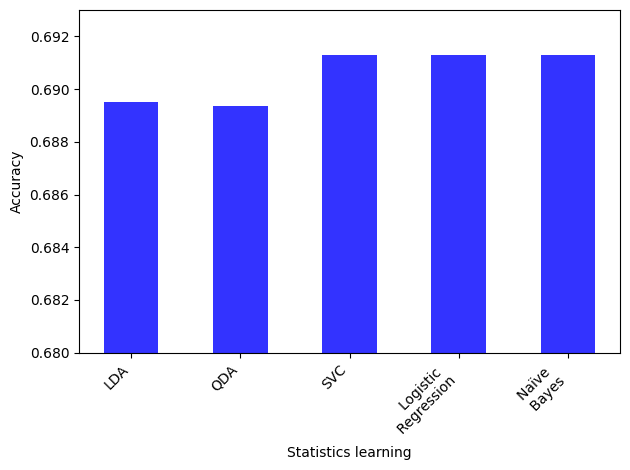

In [77]:
# Példa adatok létrehozása (itt kicserélheted a saját adataidra)

# Oszlopdiagram elkészítése
fig, ax = plt.subplots()

# Oszlopok pozíciója
x_pos = np.arange(len(labels))

# Oszlopok szélessége
width = 0.5

# Oszlopok létrehozása
rects = ax.bar(x_pos, values, width, color='b', alpha=0.8)

# Oszlopok számértékének hozzáadása
for i, rect in enumerate(rects):
    height = rect.get_height()
    #ax.text(rect.get_x() + rect.get_width() / 2, height, values[i], ha='center', va='bottom', rotation=45)

# Címkék beállítása
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Statistics learning')
ax.set_ylabel('Accuracy')
#ax.set_title('Címkék és hozzájuk tartozó értékek')
plt.ylim(0.68, 0.693)

# Diagram megjelenítése
plt.tight_layout()
plt.show()
